# Problem 3

Use this notebook to write your code for problem 3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 3D - Convolutional network

As in problem 2, we have conveniently provided for your use code that loads and preprocesses the MNIST data.

In [2]:
# load MNIST data into PyTorch format
import torch
import torchvision
import torchvision.transforms as transforms

# set batch size
batch_size = 32

# load training data downloaded into data/ folder
mnist_training_data = torchvision.datasets.MNIST('data/', train=True, download=True,
                                                transform=transforms.ToTensor())
# transforms.ToTensor() converts batch of images to 4-D tensor and normalizes 0-255 to 0-1.0
training_data_loader = torch.utils.data.DataLoader(mnist_training_data,
                                                  batch_size=batch_size,
                                                  shuffle=True)

# load test data
mnist_test_data = torchvision.datasets.MNIST('data/', train=False, download=True,
                                                transform=transforms.ToTensor())
test_data_loader = torch.utils.data.DataLoader(mnist_test_data,
                                                  batch_size=batch_size,
                                                  shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 263733316.70it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 78506606.50it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 125528939.57it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4097769.15it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# look at the number of batches per epoch for training and validation
print(f'{len(training_data_loader)} training batches')
print(f'{len(training_data_loader) * batch_size} training samples')
print(f'{len(test_data_loader)} validation batches')

1875 training batches
60000 training samples
313 validation batches


In [4]:
# sample model
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=0.5),

    nn.Conv2d(8, 8, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=0.5),

    nn.Flatten(),
    nn.Linear(25*8, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
)

In [5]:
# why don't we take a look at the shape of the weights for each layer
for p in model.parameters():
    print(p.data.shape)

torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([64, 200])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [6]:
# our model has some # of parameters:
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

total params: 14178


In [7]:
# For a multi-class classification problem
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

In [8]:
# Train the model for 10 epochs, iterating on the data in batches
n_epochs = 10

# store metrics
training_accuracy_history = np.zeros([n_epochs, 1])
training_loss_history = np.zeros([n_epochs, 1])
validation_accuracy_history = np.zeros([n_epochs, 1])
validation_loss_history = np.zeros([n_epochs, 1])

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/10:', end='')
    train_total = 0
    train_correct = 0
    # train
    model.train()
    for i, data in enumerate(training_data_loader):
        images, labels = data
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculate categorical cross entropy loss
        loss = criterion(output, labels)
        # backward pass
        loss.backward()
        optimizer.step()

        # track training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        # track training loss
        training_loss_history[epoch] += loss.item()
        # progress update after 180 batches (~1/10 epoch for batch size 32)
        if i % 180 == 0: print('.',end='')
    training_loss_history[epoch] /= len(training_data_loader)
    training_accuracy_history[epoch] = train_correct / train_total
    print(f'\n\tloss: {training_loss_history[epoch,0]:0.4f}, acc: {training_accuracy_history[epoch,0]:0.4f}',end='')

    # validate
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_data_loader):
            images, labels = data
            # forward pass
            output = model(images)
            # find accuracy
            _, predicted = torch.max(output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            # find loss
            loss = criterion(output, labels)
            validation_loss_history[epoch] += loss.item()
        validation_loss_history[epoch] /= len(test_data_loader)
        validation_accuracy_history[epoch] = test_correct / test_total
    print(f', val loss: {validation_loss_history[epoch,0]:0.4f}, val acc: {validation_accuracy_history[epoch,0]:0.4f}')

Epoch 1/10:...........
	loss: 0.7483, acc: 0.7564, val loss: 0.2215, val acc: 0.9362
Epoch 2/10:...........
	loss: 0.4940, acc: 0.8427, val loss: 0.3254, val acc: 0.9296
Epoch 3/10:...........
	loss: 0.4691, acc: 0.8510, val loss: 0.1887, val acc: 0.9458
Epoch 4/10:...........
	loss: 0.4515, acc: 0.8574, val loss: 0.2027, val acc: 0.9431
Epoch 5/10:...........
	loss: 0.4493, acc: 0.8573, val loss: 0.2184, val acc: 0.9445
Epoch 6/10:...........
	loss: 0.4383, acc: 0.8629, val loss: 0.1882, val acc: 0.9479
Epoch 7/10:...........
	loss: 0.4352, acc: 0.8629, val loss: 0.2596, val acc: 0.9329
Epoch 8/10:...........
	loss: 0.4319, acc: 0.8650, val loss: 0.1709, val acc: 0.9509
Epoch 9/10:...........
	loss: 0.4275, acc: 0.8669, val loss: 0.1875, val acc: 0.9453
Epoch 10/10:...........
	loss: 0.4261, acc: 0.8662, val loss: 0.1868, val acc: 0.9485


In [103]:
# TESTING FOR PART G

def eval_model_param(drop):
  model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(5,5), padding = (1, 1)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Dropout(p=1/9),

    nn.Conv2d(8, 8, kernel_size=(4,4), padding = (1, 1)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Dropout(p=1/9),

    nn.Conv2d(8, 8, kernel_size=(3,3), padding = (1, 1)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=1/9),

    nn.Conv2d(8, 8, kernel_size=(3,3), padding = (1, 1)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=1/9),

    nn.Flatten(),
    nn.Linear(288, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
  )

  for p in model.parameters():
    print(p.data.shape)

  count = 0
  for p in model.parameters():
      n_params = np.prod(list(p.data.shape)).item()
      count += n_params
  print(f'total params: {count}')

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.RMSprop(model.parameters())

  # Train the model for 10 epochs, iterating on the data in batches
  n_epochs = 1

  # store metrics
  training_accuracy_history = np.zeros([n_epochs, 1])
  training_loss_history = np.zeros([n_epochs, 1])
  validation_accuracy_history = np.zeros([n_epochs, 1])
  validation_loss_history = np.zeros([n_epochs, 1])

  for epoch in range(n_epochs):
      # print(f'Epoch {epoch+1}/10:', end='')
      train_total = 0
      train_correct = 0
      # train
      model.train()
      for i, data in enumerate(training_data_loader):
          images, labels = data
          optimizer.zero_grad()
          # forward pass
          output = model(images)
          # calculate categorical cross entropy loss
          loss = criterion(output, labels)
          # backward pass
          loss.backward()
          optimizer.step()

          # track training accuracy
          _, predicted = torch.max(output.data, 1)
          train_total += labels.size(0)
          train_correct += (predicted == labels).sum().item()
          # track training loss
          training_loss_history[epoch] += loss.item()
          # progress update after 180 batches (~1/10 epoch for batch size 32)
          # if i % 180 == 0: print('.',end='')
      training_loss_history[epoch] /= len(training_data_loader)
      training_accuracy_history[epoch] = train_correct / train_total
      #print(f'\n\tloss: {training_loss_history[epoch,0]:0.4f}, acc: {training_accuracy_history[epoch,0]:0.4f}',end='')

      # validate
      test_total = 0
      test_correct = 0
      with torch.no_grad():
          model.eval()
          for i, data in enumerate(test_data_loader):
              images, labels = data
              # forward pass
              output = model(images)
              # find accuracy
              _, predicted = torch.max(output.data, 1)
              test_total += labels.size(0)
              test_correct += (predicted == labels).sum().item()
              # find loss
              loss = criterion(output, labels)
              validation_loss_history[epoch] += loss.item()
          validation_loss_history[epoch] /= len(test_data_loader)
          validation_accuracy_history[epoch] = test_correct / test_total
      #print(f', val loss: {validation_loss_history[epoch,0]:0.4f}, val acc: {validation_accuracy_history[epoch,0]:0.4f}')
      return validation_accuracy_history[epoch]


0.0
torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 4, 4])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([64, 288])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
total params: 21618
0.9785
0.1111111111111111
torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 4, 4])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([64, 288])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
total params: 21618
0.9796
0.2222222222222222
torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 4, 4])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 3,

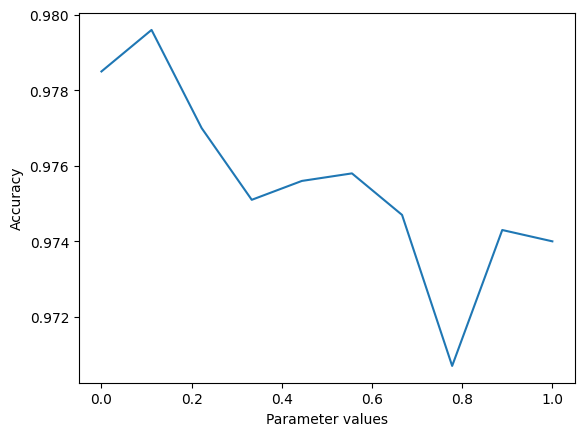

In [108]:
accuracies = []

for i in np.linspace(0, 1, 10):
  print(i)
  test = float(eval_model_param(i))
  print(test)
  accuracies.append(test)

plt.figure()
plt.plot(np.linspace(0, 1, 10), accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Parameter values")
plt.show()

In [104]:
# TESTING CASES:


print(eval_model_param(1/9))


torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 4, 4])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([64, 288])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
total params: 21618
[0.9773]


In [ ]:
# MODEL FOR PART G

In [105]:
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(5,5), padding = (1, 1)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Dropout(p=1/9),

    nn.Conv2d(8, 8, kernel_size=(4,4), padding = (1, 1)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Dropout(p=1/9),

    nn.Conv2d(8, 8, kernel_size=(3,3), padding = (1, 1)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=1/9),

    nn.Conv2d(8, 8, kernel_size=(3,3), padding = (1, 1)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(p=1/9),

    nn.Flatten(),
    nn.Linear(288, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
  )

In [106]:
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

total params: 21618


In [107]:
# Train the model for 10 epochs, iterating on the data in batches
n_epochs = 10

# store metrics
training_accuracy_history = np.zeros([n_epochs, 1])
training_loss_history = np.zeros([n_epochs, 1])
validation_accuracy_history = np.zeros([n_epochs, 1])
validation_loss_history = np.zeros([n_epochs, 1])

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/10:', end='')
    train_total = 0
    train_correct = 0
    # train
    model.train()
    for i, data in enumerate(training_data_loader):
        images, labels = data
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculate categorical cross entropy loss
        loss = criterion(output, labels)
        # backward pass
        loss.backward()
        optimizer.step()

        # track training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        # track training loss
        training_loss_history[epoch] += loss.item()
        # progress update after 180 batches (~1/10 epoch for batch size 32)
        if i % 180 == 0: print('.',end='')
    training_loss_history[epoch] /= len(training_data_loader)
    training_accuracy_history[epoch] = train_correct / train_total
    print(f'\n\tloss: {training_loss_history[epoch,0]:0.4f}, acc: {training_accuracy_history[epoch,0]:0.4f}',end='')

    # validate
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_data_loader):
            images, labels = data
            # forward pass
            output = model(images)
            # find accuracy
            _, predicted = torch.max(output.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            # find loss
            loss = criterion(output, labels)
            validation_loss_history[epoch] += loss.item()
        validation_loss_history[epoch] /= len(test_data_loader)
        validation_accuracy_history[epoch] = test_correct / test_total
    print(f', val loss: {validation_loss_history[epoch,0]:0.4f}, val acc: {validation_accuracy_history[epoch,0]:0.4f}')

Epoch 1/10:...........
	loss: 0.2521, acc: 0.9250, val loss: 0.0884, val acc: 0.9728
Epoch 2/10:...........
	loss: 0.1079, acc: 0.9669, val loss: 0.0632, val acc: 0.9777
Epoch 3/10:...........
	loss: 0.0906, acc: 0.9728, val loss: 0.0536, val acc: 0.9845
Epoch 4/10:...........
	loss: 0.0844, acc: 0.9756, val loss: 0.0453, val acc: 0.9857
Epoch 5/10:...........
	loss: 0.0774, acc: 0.9768, val loss: 0.0558, val acc: 0.9849
Epoch 6/10:...........
	loss: 0.0752, acc: 0.9785, val loss: 0.0342, val acc: 0.9895
Epoch 7/10:...........
	loss: 0.0736, acc: 0.9785, val loss: 0.0434, val acc: 0.9865
Epoch 8/10:...........
	loss: 0.0697, acc: 0.9795, val loss: 0.0448, val acc: 0.9863
Epoch 9/10:...........
	loss: 0.0682, acc: 0.9803, val loss: 0.0411, val acc: 0.9869
Epoch 10/10:...........
	loss: 0.0679, acc: 0.9804, val loss: 0.0457, val acc: 0.9855


Above, we output the training loss/accuracy as well as the validation loss and accuracy. Not bad! Let's see if you can do better.